# Tests Realised for Thymio Project

## Import Libraries

In [17]:
import sys
import os
import yaml
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tdmclient.notebook
from IPython.display import display, clear_output

from scripts.vision import Vision
from utils import utils

## Import Configuration File

In [19]:
# Get current directory
current_dir = os.getcwd()

# Assuming you're in variance_calculation folder and scripts is at the same level:
# Add the parent directory to system path to access scripts folder
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

config_path = os.path.join(parent_dir, 'config', 'config.yaml')

# Load the config file
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# Genral configuration
DT = config['time_step']
KIDNAP_THRESHOLD = config['kidnapping_threshold']

# Webcam configuration
webcam_device_id = config['webcam']['device_id'] 

# World configuration
world_width = config['world']['width']  # mm
world_height = config['world']['height']  # mm

# Thymio configuration
thymio_width = config['thymio']['width']  # mm
thymio_height = config['thymio']['length']  # mm$
thymio_wheel_base = config['thymio']['wheel_base']  # mm
thymio_weel_radius = config['thymio']['wheel_radius']  # mm 

vision = Vision(webcam_device_id)

Vision initialized correctly.


## Connect to Thymio

In [5]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

@tdmclient.notebook.sync_var
def set_motor_speed(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right

@tdmclient.notebook.sync_var
def get_motor_speed():
    global motor_left_speed, motor_right_speed
    return motor_left_speed, motor_right_speed

@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0

Successfully connected to Thymio.


## Speed Conversion Test

In [13]:
def calculate_speed(wheel_radius, num_rotations, time_seconds):
    circumference = 2 * wheel_radius * np.pi     # 2 * π * radius
    distance = circumference * num_rotations     # total distance traveled
    speed = distance / time_seconds              # speed in mm/s
    return speed

In [ ]:
# Set the speed of the robot
measuremend_time = 10
speed_settings = [50, 75, 100, 150, 200]
speed_to_coeffs = {speed: [] for speed in speed_settings}  # Dictionary to store coeffs for each speed
mean_coeffs = {}  # Dictionary to store mean coeff for each speed

print("Starting speed calibration measurements")
for speed_setting in speed_settings:
    for trial in range(3):
        # In your loop:
        clear_output(wait=True)  # This clears the previous output
        display(f"Trial {trial + 1} for speed setting: {speed_setting}")
        input("Press Enter to start counting rotations...")
        set_motor_speed(speed_setting, speed_setting)
        time.sleep(measuremend_time)
        motor_stop()
        rotations = float(input(f"Enter number of rotations counted in {measuremend_time} seconds: "))
    
        # Calculate actual speed in mm/s
        speed_mms = calculate_speed(thymio_weel_radius, rotations, measuremend_time)
        
        # Calculate conversion coefficient (setting/actual_speed)
        coeff = speed_setting / speed_mms
        speed_to_coeffs[speed_setting].append(coeff)

    # Calculate mean coefficient for this speed
    mean_coeffs[speed_setting] = np.mean(speed_to_coeffs[speed_setting])

# Print results
print("\nConversion coefficients for each speed:")
print("Speed Setting | Mean Coefficient | Individual Trials")
print("-------------|------------------|------------------")
for speed, coeffs in speed_to_coeffs.items():
    trials_str = ", ".join([f"{c:.4f}" for c in coeffs])
    print(f"{speed:12d} | {mean_coeffs[speed]:15.4f} | {trials_str}")

overall_mean = np.mean([coeff for coeffs in speed_to_coeffs.values() for coeff in coeffs])
print(f"\nOverall mean conversion coefficient: {overall_mean:.4f}")

'Trial 3 for speed setting: 200'


Conversion coefficients for each speed:
Speed Setting | Mean Coefficient | Individual Trials
-------------|------------------|------------------
          50 |          3.0462 | 3.0607, 3.1085, 2.9693
          75 |          2.8424 | 2.8421, 2.8020, 2.8832
         100 |          2.9012 | 2.9473, 2.8625, 2.8937
         150 |          2.9404 | 2.9842, 2.9256, 2.9114
         200 |          3.0030 | 3.0029, 2.9916, 3.0143

Overall mean conversion coefficient: 2.9466


## Camera Covariance Test

In [ ]:
# Initialize arrays to store positions and orientations
n_samples = 500
positions = np.zeros((n_samples, 2))  # For x,y positions
orientations = np.zeros(n_samples)    # For orientation values

Vision initialized correctly.


In [7]:
vision.connect_webcam()

try:
   # Collect data
    print("Collecting camera data...")
    vision.get_perspective_parameters(world_width, world_height)
    found_thymio = False
    for i in tqdm(range(n_samples)):
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        if found_thymio:
            positions[i] = thymio_pos[:2] # Store x,y positions
            orientations[i] = thymio_pos[2] # Store orientation values
        else:
            print("Thymio not found")   
            i -= 1
        time.sleep(DT)
except KeyboardInterrupt:
    pass
finally:
    vision.disconnect_webcam()

Webcam connected correctly.
Find all four corners!
Got a valid perspective matrix and a defined roi!


  0%|          | 0/500 [00:00<?, ?it/s]

Webcam disconnected correctly.


In [8]:
# Calculate variances (covariances with themselves)
pos_mean = np.mean(positions, axis=0)
x_variance = np.var(positions[:, 0])
y_variance = np.var(positions[:, 1])
orientation_variance = np.var(orientations)

print("\nCovariance Results:")
print(f"X position variance: {x_variance:.8f}")
print(f"Y position variance: {y_variance:.8f}")
print(f"Orientation variance: {orientation_variance:.8f}")


Covariance Results:
X position variance: 0.08497380
Y position variance: 0.11697213
Orientation variance: 0.00000717


## Translation Velocity Covariance Test


In [ ]:

all_samples = []
target_speeds = [50, 100, 150, 200]

for target_v in target_speeds:
    input(f"Press enter for speed {target_v}...")
    for i in range(5):
        input("Press enter for next trial...")
        print(f"Testing speed: {target_v}, trial {i + 1}")
        clear_output(wait=True)
        set_motor_speed(target_v, target_v)
        time.sleep(1)  # Stabilize
        
        samples = []
        for _ in range(50):
            left, right = get_motor_speed()
            v = (left + right) / 2
            samples.append(v)
            time.sleep(DT)
        
        all_samples.extend(samples)
        motor_stop()

# Organize and analyze data
samples_array = np.array(all_samples)
samples_per_trial = 50
trials_per_speed = 5
idx = 0

stats = {}
for speed in target_speeds:
    speed_trials = []
    for _ in range(trials_per_speed):
        trial = samples_array[idx:idx + samples_per_trial]
        speed_trials.append(trial)
        idx += samples_per_trial
        
    trial_means = [np.mean(trial) for trial in speed_trials]
    coefficients = [mean/speed for mean in trial_means]
    variances = [np.var(trial) for trial in speed_trials]
    
    stats[speed] = {
        'mean_velocity': np.mean(trial_means),
        'coefficients': coefficients, 
        'mean_coefficient': np.mean(coefficients),
        'variance': np.mean(variances)
    }

# Print results
print("\nSpeed | Mean Coef | Individual Coefficients")
print("------|-----------|----------------------")
for speed in target_speeds:
    coeffs = stats[speed]['coefficients']
    print(f"{speed:4d} | {stats[speed]['mean_coefficient']:.4f} | {', '.join([f'{c:.4f}' for c in coeffs])}")

overall_var = np.mean([s['variance'] for s in stats.values()])
overall_coef = np.mean([s['mean_coefficient'] for s in stats.values()])
print(f"\nOverall variance: {overall_var:.4f}")
print(f"Overall coefficient: {overall_coef:.4f}")




Speed | Mean Coef | Individual Coefficients
------|-----------|----------------------
  50 | 0.9876 | 0.9752, 0.9718, 1.0054, 0.9930, 0.9924
 100 | 0.9900 | 1.0093, 0.9698, 1.0191, 0.9574, 0.9942
 150 | 0.9916 | 0.9902, 0.9815, 1.0045, 0.9954, 0.9866
 200 | 1.0040 | 1.0077, 0.9962, 1.0041, 1.0052, 1.0066

Overall variance: 71.4096
Overall coefficient: 0.9933


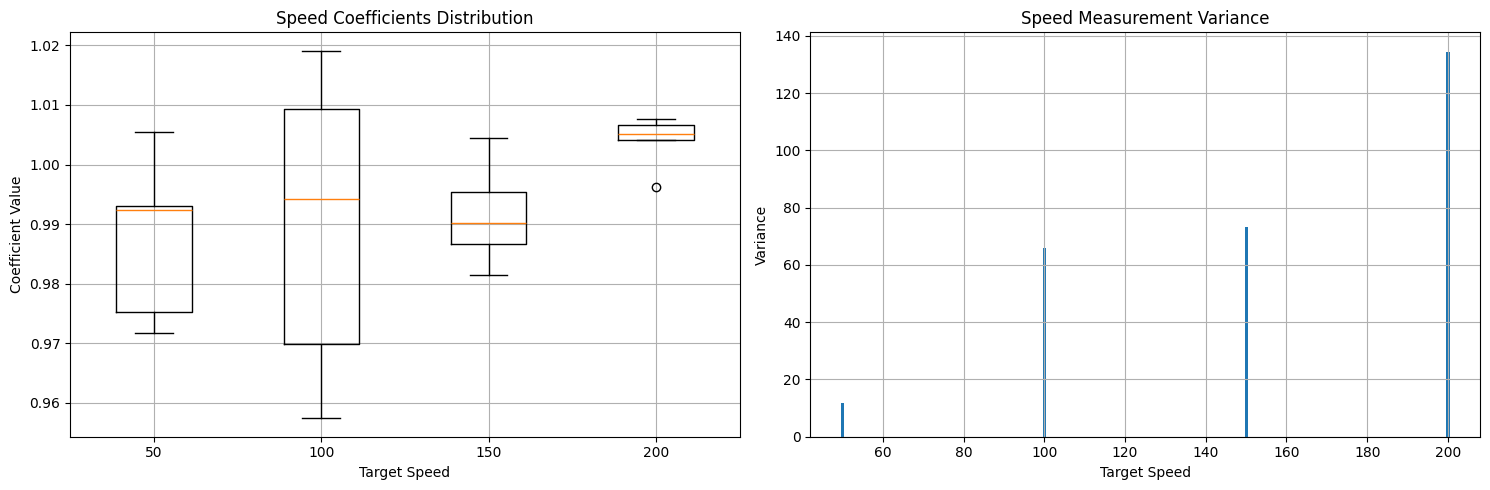

In [ ]:
speeds = list(stats.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Coefficients distribution
coeffs = [stats[s]['coefficients'] for s in speeds]
ax1.boxplot(coeffs, tick_labels=speeds)
ax1.set_xlabel('Target Speed')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Speed Coefficients Distribution')
ax1.grid(True)

# Plot 2: Variances
variances = [stats[s]['variance'] for s in speeds]
ax2.bar(speeds, variances)
ax2.set_xlabel('Target Speed')
ax2.set_ylabel('Variance')
ax2.set_title('Speed Measurement Variance')
ax2.grid(True)

plt.tight_layout()
plt.show()


## Angular Velocity Covariance Test

In [14]:
all_samples = []
target_speeds = [50, 100, 150, 200]

for target_v in target_speeds:
   input(f"Press enter for speed {target_v}...")
   for i in range(5):
       input("Press enter for next trial...")
       print(f"Testing angular speed: {target_v}, trial {i + 1}")
       clear_output(wait=True)
       set_motor_speed(target_v, -target_v)  # Opposite speeds for rotation
       time.sleep(1)
       
       samples = []
       for _ in range(50):
           left, right = get_motor_speed()
           omega = (right - left) 
           samples.append(omega)
           time.sleep(DT)
       
       all_samples.extend(samples)
       motor_stop()

# Analysis
samples_array = np.array(all_samples)
samples_per_trial = 50
trials_per_speed = 5
idx = 0

stats = {}
for speed in target_speeds:
   speed_trials = []
   for _ in range(trials_per_speed):
       trial = samples_array[idx:idx + samples_per_trial]
       speed_trials.append(trial)
       idx += samples_per_trial
       
   trial_means = [np.mean(trial) for trial in speed_trials]
   coefficients = [mean/(2*speed) for mean in trial_means]  # Normalize by expected angular speed
   variances = [np.var(trial) for trial in speed_trials]
   
   stats[speed] = {
       'mean_omega': np.mean(trial_means),
       'coefficients': coefficients, 
       'mean_coefficient': np.mean(coefficients),
       'variance': np.mean(variances)
   }

print("\nSpeed | Mean Coef | Individual Coefficients")
print("------|-----------|----------------------")
for speed in target_speeds:
   coeffs = stats[speed]['coefficients']
   print(f"{speed:4d} | {stats[speed]['mean_coefficient']:.4f} | {', '.join([f'{c:.4f}' for c in coeffs])}")

overall_var = np.mean([s['variance'] for s in stats.values()])
overall_coef = np.mean([s['mean_coefficient'] for s in stats.values()])
print(f"\nOverall angular variance: {overall_var:.4f}")
print(f"Overall angular coefficient: {overall_coef:.4f}")


Speed | Mean Coef | Individual Coefficients
------|-----------|----------------------
  50 | -0.9827 | -0.9812, -0.9894, -0.9862, -0.9900, -0.9666
 100 | -1.0026 | -1.0016, -0.9986, -1.0008, -0.9959, -1.0160
 150 | -0.9941 | -1.0031, -0.9853, -0.9811, -0.9929, -1.0083
 200 | -0.9978 | -0.9982, -0.9839, -0.9925, -1.0044, -1.0103

Overall angular variance: 246.1112
Overall angular coefficient: -0.9943


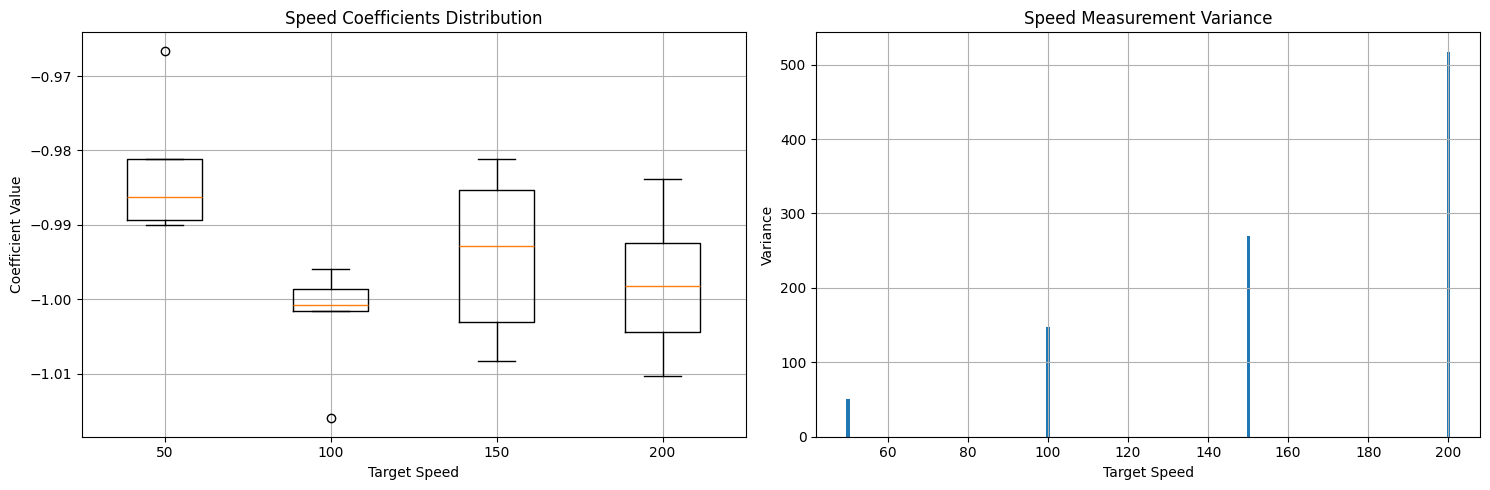

In [15]:
speeds = list(stats.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Coefficients distribution
coeffs = [stats[s]['coefficients'] for s in speeds]
ax1.boxplot(coeffs, tick_labels=speeds)
ax1.set_xlabel('Target Speed')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Speed Coefficients Distribution')
ax1.grid(True)

# Plot 2: Variances
variances = [stats[s]['variance'] for s in speeds]
ax2.bar(speeds, variances)
ax2.set_xlabel('Target Speed')
ax2.set_ylabel('Variance')
ax2.set_title('Speed Measurement Variance')
ax2.grid(True)

plt.tight_layout()
plt.show()

## X, Y position covariance 

In [ ]:
vision.connect_webcam()
vision.get_perspective_parameters(world_width, world_height)

target_speeds = [50, 100, 150, 200]
all_variances = {speed: [] for speed in target_speeds}

for speed in target_speeds:
    input(f"Testing speed {speed}...")
    for trial in range(3):
        motor_stop()
        input(f"Trial {trial + 1}: Place robot at start, press enter...")
        print(f"Testing speed: {speed}, trial {trial + 1}")
        clear_output(wait=True)
        _, process_frame = vision.get_frame()
        _, initial_pos, _ = vision.get_thymio_position(process_frame)
        print(f"Initial position: {initial_pos}")
        set_motor_speed(speed, speed)
        time.sleep(1)
        
        expected_positions = []
        actual_positions = []
        t = 0
        
        for _ in range(50):
            _, frame = vision.get_frame()
            _, pos, found = vision.get_thymio_position(frame)
            if found:
                expected_x = pos[0] + speed * np.cos(pos[2]) * t
                expected_y = pos[1] + speed * np.sin(pos[2]) * t
                
                expected_positions.append([expected_x, expected_y])
                actual_positions.append(pos[:2])
            t += DT
            time.sleep(DT)
        
        motor_stop()
        diffs = np.array(actual_positions) - np.array(expected_positions)
        position_var = np.var(diffs, axis=0)
        all_variances[speed].append(position_var)
   
vision.disconnect_webcam()
# Print results
print("\nSpeed | X Variance | Y Variance")
print("------|------------|------------")
for speed in target_speeds:
    mean_var = np.mean(all_variances[speed], axis=0)
    print(f"{speed:4d} | {mean_var[0]:10.4f} | {mean_var[1]:10.4f}")

overall_var = np.mean([np.mean(vars, axis=0) for vars in all_variances.values()], axis=0)
print(f"\nOverall variance - X: {overall_var[0]:.4f}, Y: {overall_var[1]:.4f}")


In [23]:
try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {webcam_device_id}")
    start_time = time.time()
    while time.time() - start_time < 30:
        original_frame = vision._get_original_frame()
        utils.display_frames(original_frame, None, None)
except KeyboardInterrupt:
    pass
finally:
    vision.disconnect_webcam()

Webcam disconnected correctly.
